# Automatic night input

This script let you set the night in the database automatically. It use the light sensor data to compute it.

If first shows the day/night graph and corresponding date/time and ask for confirmation on the value found

| ![](../images/autonight.jpg) | 
|:--:| 
|Example of graph obtain with autonight. At the beginning of the experiment one can see the high lights while the experiment is starting, then the plateau when lights are on, and the 2nd plateau representing the night, and again on light phase **horizontal red line**:automatic threshold on light value. **pink zone**: dark phases found automatically, **gray zone (surimposed on pink in this example)**: dark phases previously existing in the sequence |

Code launched.
Processing file E:/all_data_usv_pairs/20191112_shank3_9187_9518_two_micros_Experiment 643/20191112_shank3_9187_9518_two_micros_Experiment 643.sqlite
--------------
Current file:  E:/all_data_usv_pairs/20191112_shank3_9187_9518_two_micros_Experiment 643/20191112_shank3_9187_9518_two_micros_Experiment 643.sqlite
night  Id( None , None , None , None ) Min/maxFrame: ( None / None ) Loaded ( 5  records loaded in  5.114268064498901 S )
Loading animals.
Fields available in lmtanalysis:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:2 Name:B RFID:000004849518 Genotype:S User1:None
Animal Id:1 Name:A RFID:000004849187 Genotype:SH3 User1:None
plotting sensor data.  LIGHTVISIBLE
night  Id( None , None , None , None ) Min/maxFrame: ( None / None ) Loaded ( 5  records loaded in  0.6818745136260986 S )
std: 10.012922724030055
Saving figure : E:/all_data_usv_pairs/20191112_shank3_9187_9518_two_micros_Experiment 643/20

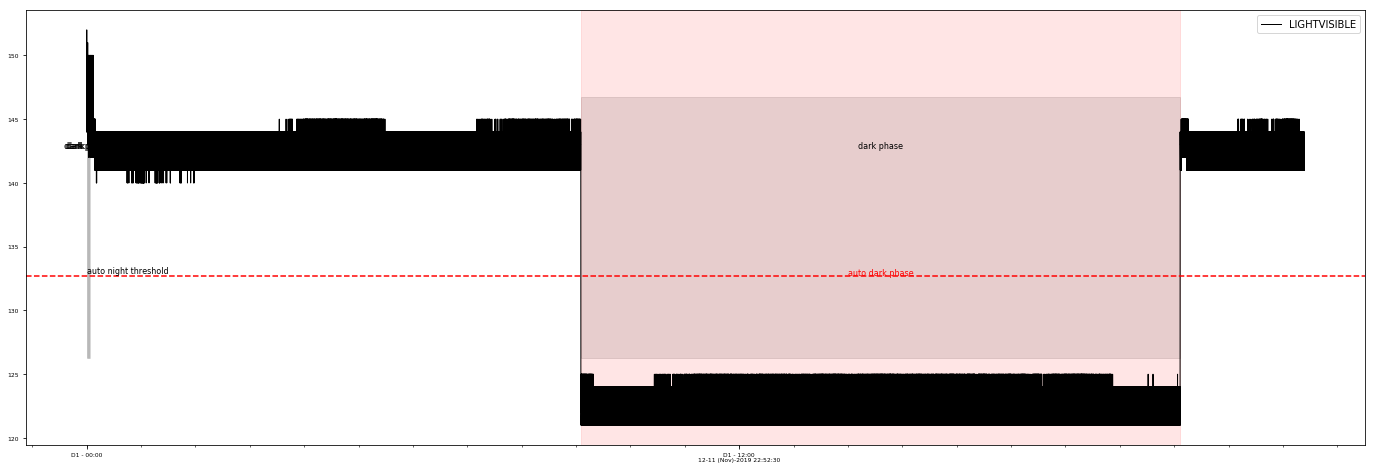

Night # 1
Starts at  12-11 (Nov)-2019 19:57:37
Ends at  13-11 (Nov)-2019 06:59:02
Set night(s) with autoNight data ? [Y/N]:y
Setting events...
night  Id( None , None , None , None ) Min/maxFrame: ( None / None ) Loaded ( 5  records loaded in  0.5957636833190918 S )
Number of event:  1
Mean length of event:  1190345.0
first event frame:  981283
Keep previous entry.
Saving timeLine: night ( 1 events )
Setting events... Done
*** ALL JOBS DONE ***


In [3]:
import sys
sys.path.insert(1, "../")

import sqlite3
from lmtanalysis.Animal import *
from lmtanalysis.Event import *
from lmtanalysis.Measure import *
from tkinter.filedialog import askopenfilename
import sys
from lmtanalysis.FileUtil import getFilesToProcess

class FileProcessException(Exception):
    pass

def getDateTime( animalPool, frame ):

    if frame > 0:
        
        datetime = getDatetimeFromFrame( animalPool.conn , frame )
        if datetime != None:
            realTime = getDatetimeFromFrame( animalPool.conn , frame ).strftime('%d-%m (%b)-%Y %H:%M:%S')
            return realTime
    return None


def process( file ):
    
    connection = sqlite3.connect( file )     

    print( "--------------")
    print( "Current file: ", file )
    
    nightTimeLine = EventTimeLine( connection, "night" , None, None, None , None )
    nightTimeLine.eventList.clear()
    
    connection = sqlite3.connect( file )
    # build sensor data
    animalPool = AnimalPool( )
    animalPool.loadAnimals( connection )
    autoNightList = animalPool.plotSensorData( 
        sensor = "LIGHTVISIBLE" , minValue = 40 , saveFile = file+"_log_light visible.pdf", show = True, autoNight = True  )
    
    # show nights 
    
    nightNumber = 1

    if autoNightList == None:
        print("No sensor data found.")
        return
    
    for autoNight in autoNightList:
        print( "Night #" , str( nightNumber ) )
        print( "Starts at " , getDateTime( animalPool , autoNight[0] ) )
        print( "Ends at " , getDateTime( animalPool, autoNight[1]) )
        
        nightNumber+=1
    
    # ask confirmation
        
    answer = input ("Set night(s) with autoNight data ? [Y/N]:")
    if answer.lower() == "y":
        print("Setting events...")
        
        nightTimeLine = EventTimeLine( connection, "night" , None, None, None , None )        
        nightTimeLine.eventList.clear()
              
        for autoNight in autoNightList:
            nightTimeLine.addEvent( Event( autoNight[0], autoNight[1] ) )
              
        nightTimeLine.endRebuildEventTimeLine(connection)
        print("Setting events... Done")
    else:
        print("autoNight canceled.")
    
print("Code launched.")

files = getFilesToProcess()

if ( files != None ):

    for file in files:
        try:
            print ( "Processing file" , file )
            process( file )
        except FileProcessException:
            print ( "STOP PROCESSING FILE " + file , file=sys.stderr  )

print( "*** ALL JOBS DONE ***")